## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


# 1. Подготовка

In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from statsmodels.iolib.table import SimpleTable
import math

In [141]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])#запись датасета
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [142]:
data = data.resample('1H').sum()#ресемплирование
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


Данные прочлись нормально, пропусков нет. Разделю данные на обучающую и тестовую выборки.

In [4]:
train_1, test = train_test_split(data, shuffle=False, test_size=0.1)
train, valid = train_test_split(train_1, shuffle=False, test_size=0.1)
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [5]:
data.head(40)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


Данные прочлись, можем приступить к анализу.

# 2. Анализ

Взглянем на распределение.

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


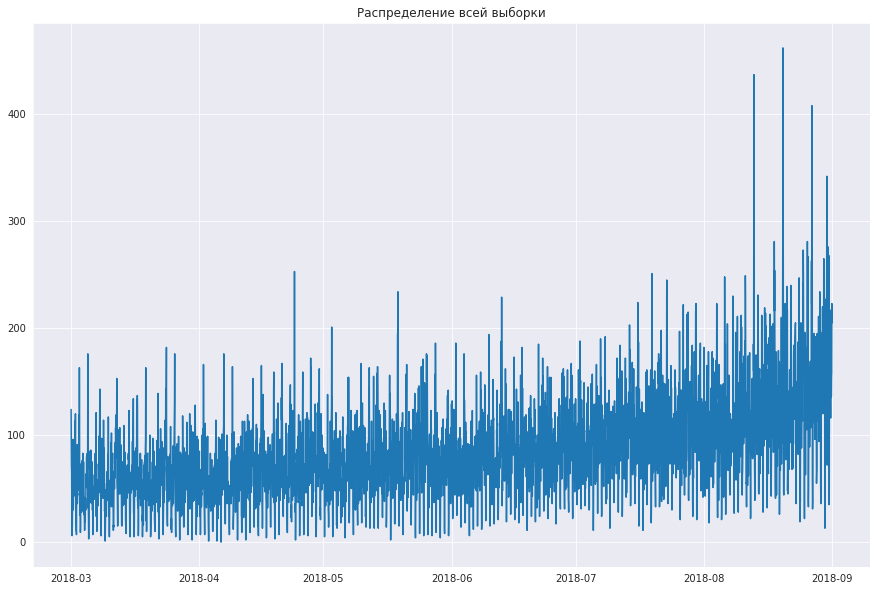

In [6]:
sns.set_style("darkgrid")#Построение графика
plt.figure(figsize=(15,10))
plt.plot(data)
plt.title('Распределение всей выборки')
plt.show()

На первый взгляд ряд кажется нестационарным, так как наростает. Взглянем на недельный отрезок.

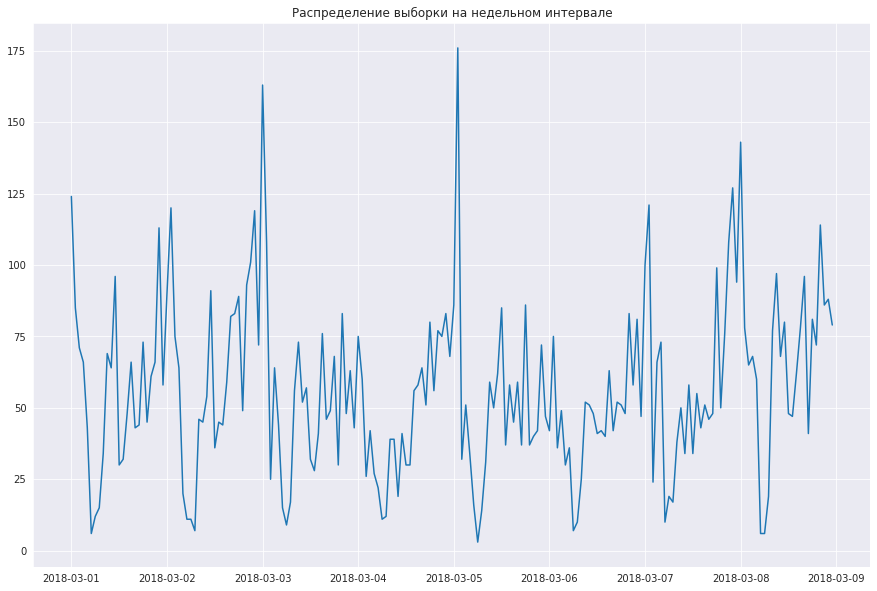

In [7]:
sns.set_style("darkgrid")
plt.figure(figsize=(15,10))
plt.plot(data['2018-03-01':'2018-03-08'])
plt.title('Распределение выборки на недельном интервале')
plt.show()

За неделю график кажется стационарным, да и симметричным, визуально легко выделить паттерны. Больше всего такси заказывают в 12 ночи, затем идет резкое падение количества заказов, в целом по дню число заказов растет ближе к вечеру, так же наблюдаются отдельные маленькие пики в определенные часы, возможно это обед и конец рабочего для....

In [143]:
#Создаю сезонные составляющие тренда

res = sm.tsa.seasonal_decompose(data)

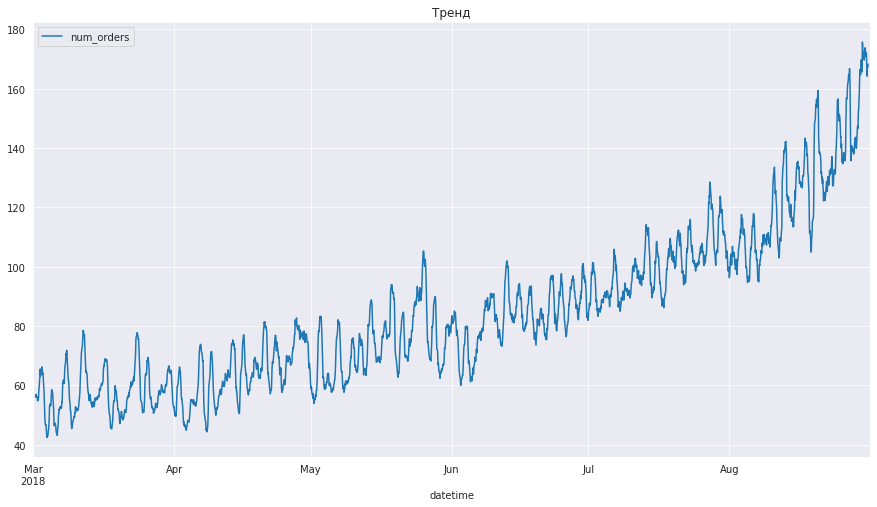

In [147]:
res.trend.plot(title = 'Тренд',figsize=(15,8))

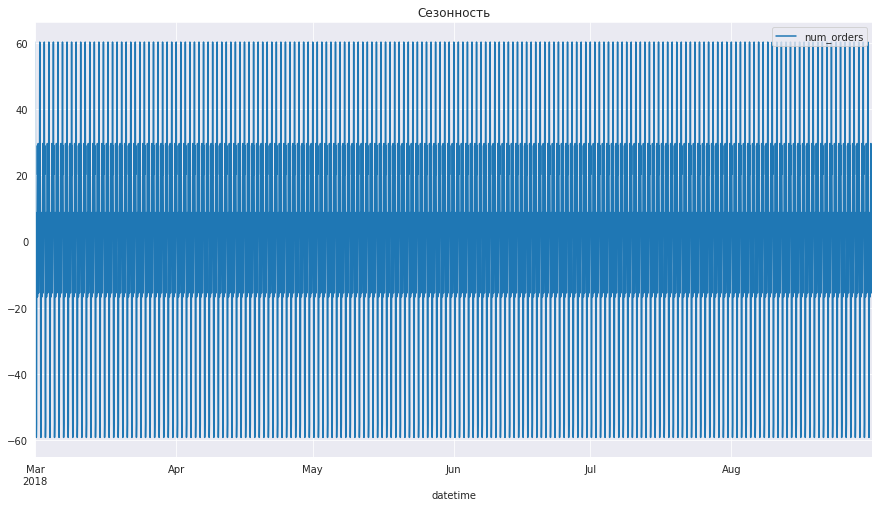

In [146]:
res.seasonal.plot(title = 'Сезонность',figsize=(15,8))

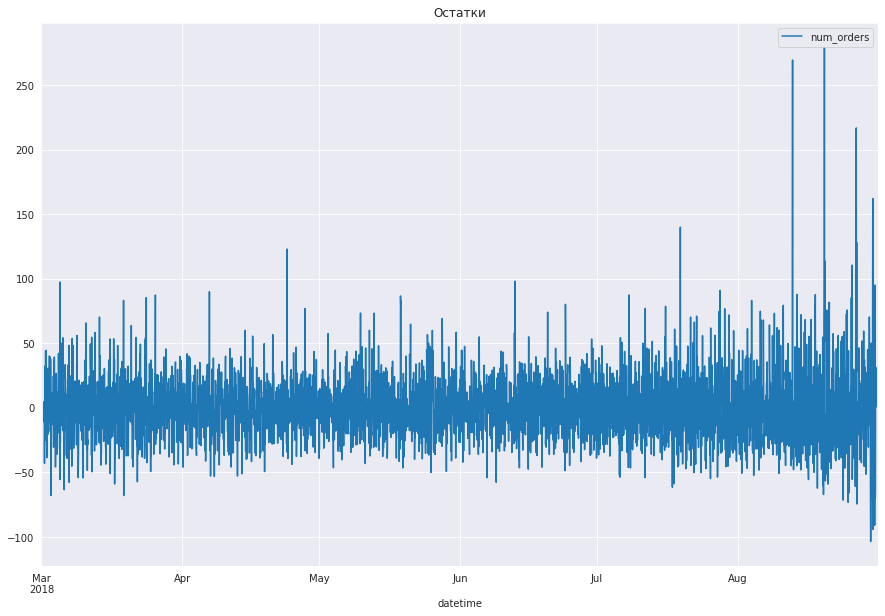

In [148]:
res.resid.plot(title = 'Остатки',figsize=(15,10))

Трудно разглядеть характер сезонности, по этому уменьшу масштаб.

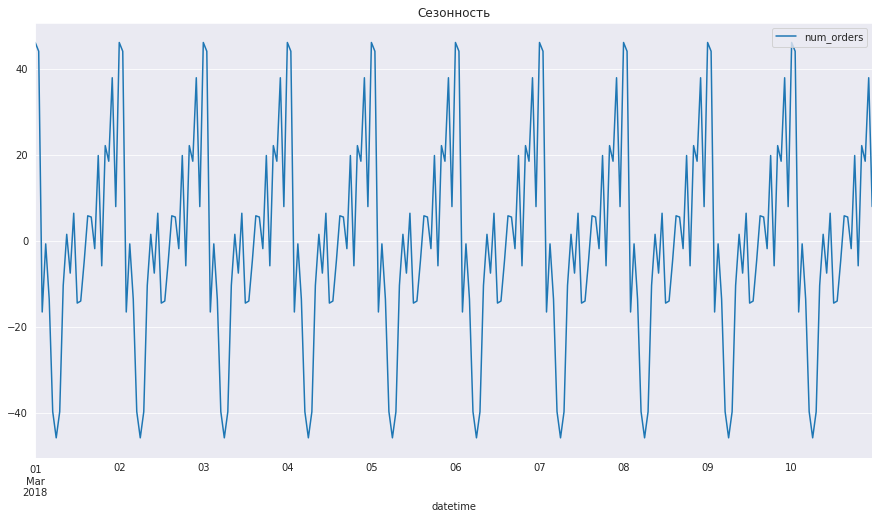

In [150]:
res = sm.tsa.seasonal_decompose(data['2018-03-01':'2018-03-10'])
res.seasonal.plot(title = 'Сезонность',figsize=(15,8))

Судя по графикам в ряде есть устойчивый нарастающий тренд, присутствует дневная сезонность и есть остатки, которые по большей части распределены линейно и кажутся выбросами в большую или меньшую стороны.

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


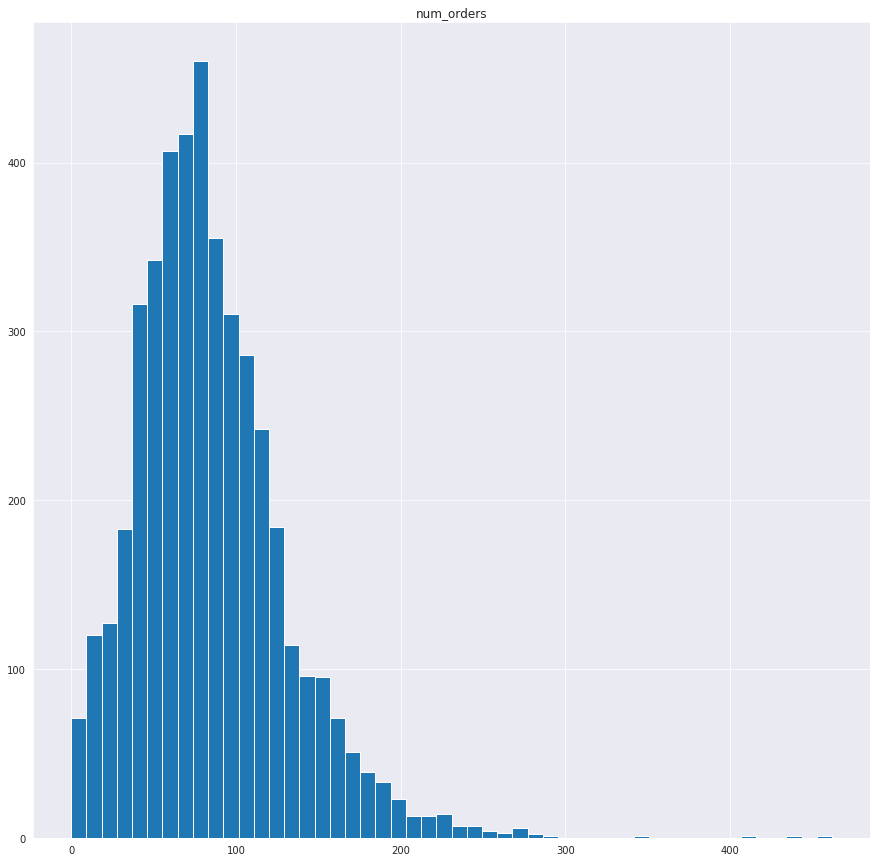

In [8]:
itog = data.describe()
data.hist(figsize=(15,15),bins=50)
itog

Распределение заказов такси выглядит нормальным. Есть выбросы более 300 заказов за час, взглянем на них.

In [9]:
data.loc[data['num_orders']>300]

,num_orders
datetime,
2018-08-13 02:00:00,437
2018-08-20 02:00:00,462
2018-08-27 02:00:00,408
2018-08-30 17:00:00,342


Так как таких значений очень мало и прогнозировать эти выбросы я не намерен, то чтоб улучшить качество модели я заменю их на 290.

In [10]:
data.loc[(data.loc[data['num_orders']>300].index)] = 290
data.loc[data['num_orders']>300]

,num_orders
datetime,


Замена прошла успешно.

In [11]:
print('Коэффициент вариации =', (data['num_orders'].std()/data['num_orders'].mean()))

Коэффициент вариации = 0.5259301144297918


Судя по коэффициенту вариации выборка более-менее однородный и имеет относительно небольшой разброс, но разброс все же есть.

Проведем тест Харки — Бера для определения номарльности распределения, чтобы подтвердить предположение об однородности.

In [12]:
row =  [u'JB', u'p-value', u'skew', u'kurtosis']#перечисляю столбци для вывода
jb_test = sm.stats.stattools.jarque_bera(data['num_orders'])#провожу статтест
a = np.vstack([jb_test])#сохраняю данные результата
itog = SimpleTable(a, row)#преобразую к удобному виду
print(itog)

        JB               p-value                skew             kurtosis    
-----------------------------------------------------------------------------
1154.830256349414 1.705281443813849e-251 0.9558373651173991 4.619182237731457
-----------------------------------------------------------------------------


Значение данной статистики свидетельствует о том, нулевая гипотеза о нормальности распределения подтверждается с высокой вероятностью (p-value < 0.05), и, следовательно, наш ряд имеет нормальное распределение.

Проведем обобщенный тест Дикки-Фуллера на наличие единичных корней.

In [13]:
test = sm.tsa.adfuller(data['num_orders'])#тест Дикки-Фуллера
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -3.0130493255628044
p-value:  0.03369359785157683
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
единичных корней нет, ряд стационарен


Как видим: по результатам теста можно судить о том, что ряд стационарен.

Вывод: данные нормально распределены и имеют стационарный характер, так же я удалил выбросы более 300 заказов такси за час.

# 3. Обучение

Разделю выборку на обучающую, валидационную и тестовую.

In [14]:
train_1, test = train_test_split(data, shuffle=False, test_size=0.1)
train, valid = train_test_split(train_1, shuffle=False, test_size=0.1)

In [15]:
train

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-07-27 19:00:00,86
2018-07-27 20:00:00,131
2018-07-27 21:00:00,133


In [16]:
valid

,num_orders
datetime,
2018-07-28 00:00:00,192
2018-07-28 01:00:00,195
2018-07-28 02:00:00,145
2018-07-28 03:00:00,132
2018-07-28 04:00:00,215
...,...
2018-08-13 09:00:00,137
2018-08-13 10:00:00,156
2018-08-13 11:00:00,144


In [17]:
test

,num_orders
datetime,
2018-08-13 14:00:00,102
2018-08-13 15:00:00,175
2018-08-13 16:00:00,144
2018-08-13 17:00:00,152
2018-08-13 18:00:00,104
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


С начала я попробую построить модель с помощью авторегрессионной модели ARIMA. У нее есть параметры p, d, q. Так как ряд стационарен, d = 0, для определения других параметров построю кореллограммы. ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA. PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.

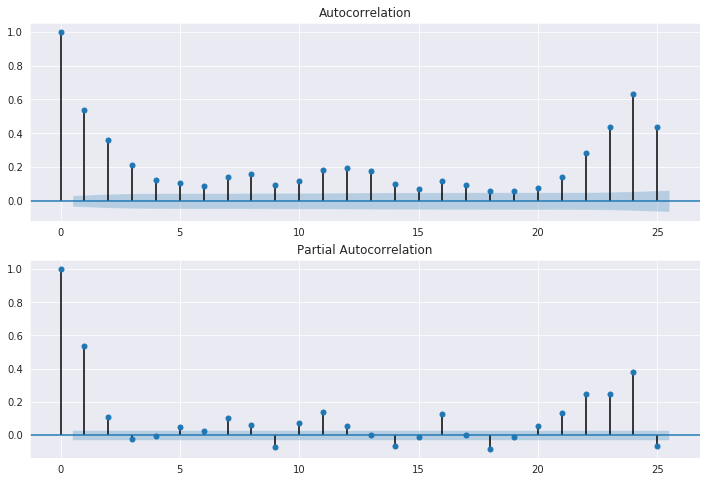

In [18]:
#кореллограммы для построения модели ARIMA
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train, lags=25, ax=ax2)

По автокорреляционнму ACF графику можно сделать вывод о том, что в ряде присутствует сезонность, по нему я б выделил q = 6, по графику частных корреляций можно выделить p = 3. Передам такие параметры модели. На самом деле эти числа немного больше, но код крашится при запуске с большими значениями q и p.

In [19]:
model = sm.tsa.ARIMA(data[:'2018-07-27 23:00:00'], order=(6,0,3)).fit(full_output=False, disp=0,MaxIter=700)#
print(model.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                              ARMA Model Results                              
Dep. Variable:             num_orders   No. Observations:                 3576
Model:                     ARMA(6, 3)   Log Likelihood              -17079.546
Method:                       css-mle   S.D. of innovations             28.654
Date:                Tue, 29 Dec 2020   AIC                          34181.092
Time:                        15:32:21   BIC                          34249.094
Sample:                    03-01-2018   HQIC                         34205.334
                         - 07-27-2018                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               74.9930        nan        nan        nan         nan         nan
ar.L1.num_orders     0.0546        nan        nan        nan         nan         nan
ar.L2.num_orders     0.6749 

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


In [20]:
pred = model.predict('2018-07-28 00:00:00','2018-08-13 13:00:00')
print('RMSE ARIMA',(mean_squared_error(pred,valid))**(1/2))

RMSE ARIMA 44.56245436711711


Построим модель линейной регрессии, с добавлением фичей для обучения. Для начала я проанализирую сколько лагов и какое усреднение необходимо передать модели.

In [21]:
def make_features(data, max_lag, rolling_mean_size):#создаю отдельные столбци в функции и добавляю лаги
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size).mean().shift(1)
    return data
    
graph = pd.DataFrame(columns = ['ox', 'oy1', 'oy2'])#Задаю пустой список, в который потом будут вносится значения для построения графиков
a = 0#Счетчик цикла
for i in range(1,60,3):#Прогоняю параметры модели для поиска оптимальных значений
    data_11 = make_features(train_1, i,1)#генерю в цикле фичи для разбиения выборки
    train_1 = data_11.dropna()
    train, valid = train_test_split(train_1, shuffle=False, test_size=0.1)
    features_train = train.drop(['num_orders'], axis=1)
    target_train = train['num_orders']
    features_valid = valid.drop(['num_orders'], axis=1)
    target_valid = valid['num_orders']
    a += 1
    graph.loc[a,'ox'] = i#Задаю индекс строки пустого списка
    model = LinearRegression()#Создаю модель
    model.fit(features_train, target_train)#Обучаю
    train_predictions1 = model.predict(features_train)#Строю данные медли по тестовой выборке
    train_predictions2 = model.predict(features_valid)#Строю данные медли по валидационной выборке
    RMSE_1 = (mean_squared_error(target_train, train_predictions1))**(1/2)#Расчет качества модели
    RMSE_2 = (mean_squared_error(target_valid, train_predictions2))**(1/2)#Расчет качества модели
    graph.loc[a, 'oy1'] = RMSE_1#Добавляю значение в список
    graph.loc[a, 'oy2'] = RMSE_2#Добавляю значение в список
    print('max_lag=', i)#Выводжу параметры на экран
    print('RMSE для тестовой выборки: ', RMSE_1)#Выводжу параметры на экран
    print('RMSSE для валидационной выборки: ', RMSE_2)#Выводжу параметры на экран
    print()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 1
RMSE для тестовой выборки:  29.330212585278225
RMSSE для валидационной выборки:  39.20938639769752



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 4
RMSE для тестовой выборки:  29.17983869966099
RMSSE для валидационной выборки:  38.74096281129365



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 7
RMSE для тестовой выборки:  29.122786925890082
RMSSE для валидационной выборки:  38.5534420519358



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

max_lag= 10
RMSE для тестовой выборки:  28.943899993971065
RMSSE для валидационной выборки:  38.312984605871776

max_lag= 13
RMSE для тестовой выборки:  28.786048611675923
RMSSE для валидационной выборки:  38.05524563004003



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

max_lag= 16
RMSE для тестовой выборки:  28.465137520070517
RMSSE для валидационной выборки:  37.36597710291528



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

max_lag= 19
RMSE для тестовой выборки:  27.834190855065575
RMSSE для валидационной выборки:  35.97143224400014

max_lag= 22
RMSE для тестовой выборки:  27.333835184581364
RMSSE для валидационной выборки:  35.10034056963222



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

max_lag= 25
RMSE для тестовой выборки:  24.635285596686415
RMSSE для валидационной выборки:  31.949554862570384



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

max_lag= 28
RMSE для тестовой выборки:  24.276624984263098
RMSSE для валидационной выборки:  31.91730678299826



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

max_lag= 31
RMSE для тестовой выборки:  24.17619550583904
RMSSE для валидационной выборки:  31.6386466605225



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

max_lag= 34
RMSE для тестовой выборки:  24.123215959820914
RMSSE для валидационной выборки:  31.481762211768423



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

max_lag= 37
RMSE для тестовой выборки:  24.13818976061807
RMSSE для валидационной выборки:  31.482548480307113



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

max_lag= 40
RMSE для тестовой выборки:  24.116731023303096
RMSSE для валидационной выборки:  31.371244843910674



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

max_lag= 43
RMSE для тестовой выборки:  24.129896415102813
RMSSE для валидационной выборки:  31.417995349649487



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 46
RMSE для тестовой выборки:  24.114449353775065
RMSSE для валидационной выборки:  30.936877680242173



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 49
RMSE для тестовой выборки:  22.69894491966024
RMSSE для валидационной выборки:  29.166122216718982



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 52
RMSE для тестовой выборки:  22.746214202645625
RMSSE для валидационной выборки:  29.079125988307453



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 55
RMSE для тестовой выборки:  22.794728600572547
RMSSE для валидационной выборки:  28.9620048025223



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 58
RMSE для тестовой выборки:  22.780123932918933
RMSSE для валидационной выборки:  28.785211526377754



Text(0.5, 0, 'max_lag')

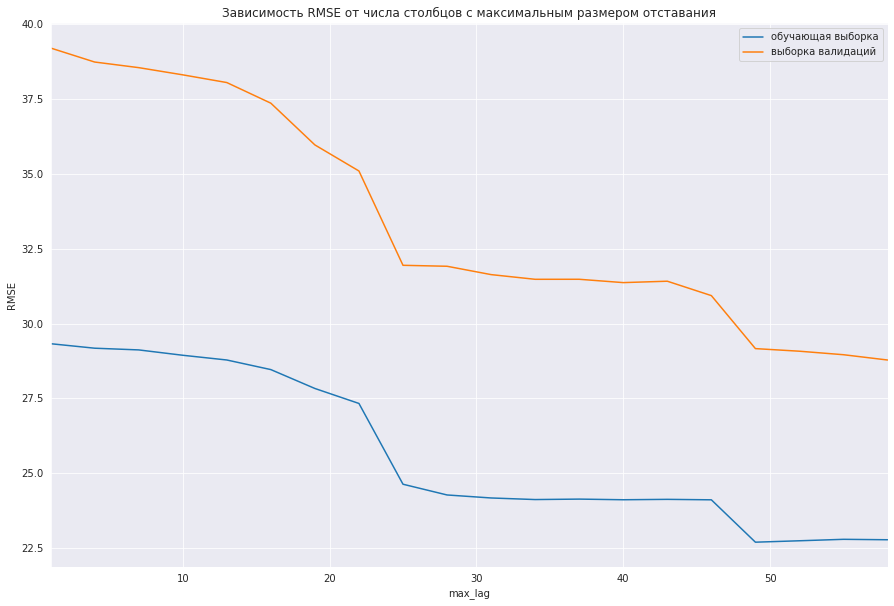

In [22]:
graph['ox'] = graph['ox'].astype('int')#Привожу данные в таблице к удобному типу для построения графика
graph['oy1'] = graph['oy1'].astype('float')
graph['oy2'] = graph['oy2'].astype('float')
ax = graph.plot(title = 'Зависимость RMSE от числа столбцов с максимальным размером отставания',x = 'ox', y= 'oy1', figsize=(15,10), grid=True, label='обучающая выборка')#Строю график
graph.plot(x = 'ox', y= 'oy2', ax=ax, grid=True, label='выборка валидаций')
ax.set_ylabel('RMSE')#Подписи осей
ax.set_xlabel('max_lag')#Подписи осей

Судя по всему качество модели зависит не от количества лагов, а от каких то конкретных лагов, судя по резком скачакам RMSE, проверим как поведет себя эта метрика при изменении скользящего среднего.

In [23]:
train_1, test = train_test_split(data, shuffle=False, test_size=0.1)#перезаписываю разбиения
train, valid = train_test_split(train_1, shuffle=False, test_size=0.1)

In [24]:
    
graph = pd.DataFrame(columns = ['ox', 'oy1', 'oy2'])#Задаю пустой список, в который потом будут вносится значения для построения графиков
a = 0#Счетчик цикла
for i in range(1,20,1):#Прогоняю параметры модели для поиска оптимальных значений
    data_11 = make_features(train_1, 50,i)
    train_1 = data_11.dropna()
    train, valid = train_test_split(train_1, shuffle=False, test_size=0.1)
    features_train = train.drop(['num_orders'], axis=1)
    target_train = train['num_orders']
    features_valid = valid.drop(['num_orders'], axis=1)
    target_valid = valid['num_orders']
    a += 1
    graph.loc[a,'ox'] = i#Задаю индекс строки пустого списка
    model = LinearRegression()#Создаю модель
    model.fit(features_train, target_train)#Обучаю
    train_predictions1 = model.predict(features_train)#Строю данные медли по тестовой выборке
    train_predictions2 = model.predict(features_valid)#Строю данные медли по валидационной выборке
    RMSE_1 = (mean_squared_error(target_train, train_predictions1))**(1/2)#Расчет качества модели
    RMSE_2 = (mean_squared_error(target_valid, train_predictions2))**(1/2)#Расчет качества модели
    graph.loc[a, 'oy1'] = RMSE_1#Добавляю значение в список
    graph.loc[a, 'oy2'] = RMSE_2#Добавляю значение в список
    print('rolling_mean_size=', i)#Выводжу параметры на экран
    print('RMSE для тестовой выборки: ', RMSE_1)#Выводжу параметры на экран
    print('RMSSE для валидационной выборки: ', RMSE_2)#Выводжу параметры на экран
    print()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 1
RMSE для тестовой выборки:  22.314431055132665
RMSSE для валидационной выборки:  29.017992049836245



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

rolling_mean_size= 2
RMSE для тестовой выборки:  22.33850482466638
RMSSE для валидационной выборки:  29.11170266586887



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 3
RMSE для тестовой выборки:  22.407725858428662
RMSSE для валидационной выборки:  29.150464454538866



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

rolling_mean_size= 4
RMSE для тестовой выборки:  22.410650062035216
RMSSE для валидационной выборки:  29.13092213908908



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 5
RMSE для тестовой выборки:  22.538117027802897
RMSSE для валидационной выборки:  29.263099243589647



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 6
RMSE для тестовой выборки:  22.518410478822243
RMSSE для валидационной выборки:  29.08306885375864



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

rolling_mean_size= 7
RMSE для тестовой выборки:  22.60327455542236
RMSSE для валидационной выборки:  29.170606674587773



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

rolling_mean_size= 8
RMSE для тестовой выборки:  22.65355260726285
RMSSE для валидационной выборки:  29.112013380750938



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 9
RMSE для тестовой выборки:  22.674274953998985
RMSSE для валидационной выборки:  29.25339308998545



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 10
RMSE для тестовой выборки:  22.824805803152
RMSSE для валидационной выборки:  29.071607248468982



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


rolling_mean_size= 11
RMSE для тестовой выборки:  22.866559388555224
RMSSE для валидационной выборки:  28.807107472105322



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 12
RMSE для тестовой выборки:  22.90195874170196
RMSSE для валидационной выборки:  28.87549173090606



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 13
RMSE для тестовой выборки:  22.97639281019855
RMSSE для валидационной выборки:  28.939641828709956



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


rolling_mean_size= 14
RMSE для тестовой выборки:  23.06793380194706
RMSSE для валидационной выборки:  28.92414466983682



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 15
RMSE для тестовой выборки:  23.153244999698792
RMSSE для валидационной выборки:  28.952854034837696



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 16
RMSE для тестовой выборки:  23.25684028790944
RMSSE для валидационной выборки:  28.894723970472224



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 17
RMSE для тестовой выборки:  23.39096747528266
RMSSE для валидационной выборки:  28.928484930057003



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 18
RMSE для тестовой выборки:  23.436237633245216
RMSSE для валидационной выборки:  29.01938199199276



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 19
RMSE для тестовой выборки:  23.481177042758937
RMSSE для валидационной выборки:  29.036369195477526



Text(0.5, 0, 'rolling_mean_size')

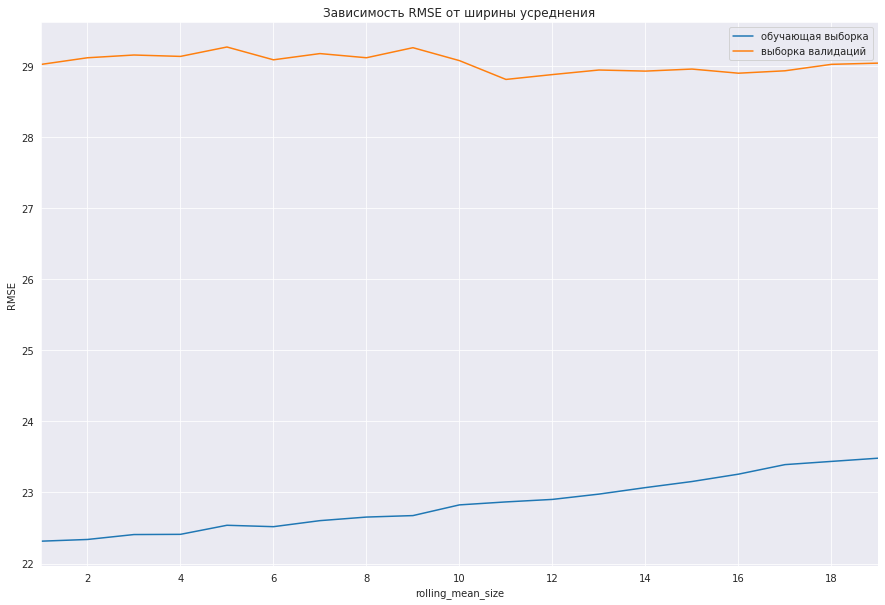

In [25]:
graph['ox'] = graph['ox'].astype('int')#Привожу данные в таблице к удобному типу для построения графика
graph['oy1'] = graph['oy1'].astype('float')
graph['oy2'] = graph['oy2'].astype('float')
ax = graph.plot(title = 'Зависимость RMSE от ширины усреднения',x = 'ox', y= 'oy1', figsize=(15,10), grid=True, label='обучающая выборка')#Строю график
graph.plot(x = 'ox', y= 'oy2', ax=ax, grid=True, label='выборка валидаций')
ax.set_ylabel('RMSE')#Подписи осей
ax.set_xlabel('rolling_mean_size')#Подписи осей

Тут я не смог определиться с усреднением, по этому возьму 11 (при большом усреднении картина не меняется).

In [26]:
train_1, test = train_test_split(data, shuffle=False, test_size=0.1)#перезаписываю разбиения
train, valid = train_test_split(train_1, shuffle=False, test_size=0.1)

data_11 = make_features(train_1, 50,11)
train_1 = data_11.dropna()
train, valid = train_test_split(train_1, shuffle=False, test_size=0.1)
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']
model = LinearRegression()#Создаю модель
model.fit(features_train, target_train)#Обучаю

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
print('RMSE линейной регрессии',(mean_squared_error(model.predict(features_valid),target_valid))**(1/2))

RMSE линейной регрессии 29.020203098558778


Так как качество модели зависит не от всех лагов, то от лагов можно избавиться, проанализировав коэффициенты при свободных членах.

In [28]:
features_train.head()

,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 02:00:00,2018,3,3,5,2,108.0,163.0,72.0,119.0,101.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,92.545455
2018-03-03 03:00:00,2018,3,3,5,3,25.0,108.0,163.0,72.0,119.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,89.454545
2018-03-03 04:00:00,2018,3,3,5,4,64.0,25.0,108.0,163.0,72.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,87.818182
2018-03-03 05:00:00,2018,3,3,5,5,44.0,64.0,25.0,108.0,163.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,84.272727
2018-03-03 06:00:00,2018,3,3,5,6,15.0,44.0,64.0,25.0,108.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,77.545455


In [29]:
features_train.columns

Index(['year', 'month', 'day', 'dayofweek', 'hour', 'lag_1', 'lag_2', 'lag_3',
       'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10',
       'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17',
       'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24',
       'lag_25', 'lag_26', 'lag_27', 'lag_28', 'lag_29', 'lag_30', 'lag_31',
       'lag_32', 'lag_33', 'lag_34', 'lag_35', 'lag_36', 'lag_37', 'lag_38',
       'lag_39', 'lag_40', 'lag_41', 'lag_42', 'lag_43', 'lag_44', 'lag_45',
       'lag_46', 'lag_47', 'lag_48', 'lag_49', 'lag_50', 'rolling_mean'],
      dtype='object')

In [30]:
model.coef_

array([-3.83769627e-12,  4.60909689e+00,  2.65269075e-01,  3.00463729e-01,
       -4.09875327e-02, -2.96303471e+11, -2.96303471e+11, -2.96303471e+11,
       -2.96303471e+11, -2.96303471e+11, -2.96303471e+11, -2.96303471e+11,
       -2.96303471e+11, -2.96303471e+11, -2.96303471e+11, -2.96303471e+11,
        6.37634261e-02,  4.29183257e-02, -4.25953904e-02, -5.40234760e-02,
        1.96936652e-02,  1.03601268e-02, -1.96974615e-02, -3.87237193e-02,
        3.29857993e-03, -3.19130068e-02,  4.03659816e-02,  3.16608448e-02,
        2.58446632e-01, -1.11178101e-02, -6.28317928e-02, -4.25553378e-02,
       -6.58291105e-02, -7.78198242e-04, -2.27355957e-02, -3.16238403e-02,
       -2.33154297e-02, -3.30810547e-02, -8.23974609e-03, -5.76019287e-02,
       -5.87921143e-02, -1.08947754e-02, -1.46484375e-02, -1.83410645e-02,
        1.38473511e-02, -8.74900818e-03, -1.98211670e-02,  4.06494141e-02,
       -5.54199219e-02, -6.19506836e-03,  1.27868652e-02,  7.49511719e-02,
        3.24981689e-01,  

Единственный столбец который можно убрать- 'year', при нем самый малый коэффициент, но думаю удаление одного столбца не сильно упростит работу модели, по этому оставлю его)

Построю модель регрессии на рандом форест.

In [31]:
train_1, test = train_test_split(data, shuffle=False, test_size=0.1)#перезаписываю разбиения
train, valid = train_test_split(train_1, shuffle=False, test_size=0.1)

In [32]:
    
graph = pd.DataFrame(columns = ['ox', 'oy1', 'oy2'])#Задаю пустой список, в который потом будут вносится значения для построения графиков
a = 0#Счетчик цикла
for i in range(1,60,3):#Прогоняю параметры модели для поиска оптимальных значений
    data_11 = make_features(train_1, i,1)#генерю в цикле фичи для разбиения выборки
    train_1 = data_11.dropna()
    train, valid = train_test_split(train_1, shuffle=False, test_size=0.1)
    features_train = train.drop(['num_orders'], axis=1)
    target_train = train['num_orders']
    features_valid = valid.drop(['num_orders'], axis=1)
    target_valid = valid['num_orders']
    a += 1
    graph.loc[a,'ox'] = i#Задаю индекс строки пустого списка
    model = RandomForestRegressor(max_depth=30)#Создаю модель
    model.fit(features_train, target_train)#Обучаю
    train_predictions1 = model.predict(features_train)#Строю данные медли по тестовой выборке
    train_predictions2 = model.predict(features_valid)#Строю данные медли по валидационной выборке
    RMSE_1 = (mean_squared_error(target_train, train_predictions1))**(1/2)#Расчет качества модели
    RMSE_2 = (mean_squared_error(target_valid, train_predictions2))**(1/2)#Расчет качества модели
    graph.loc[a, 'oy1'] = RMSE_1#Добавляю значение в список
    graph.loc[a, 'oy2'] = RMSE_2#Добавляю значение в список
    print('max_lag=', i)#Выводжу параметры на экран
    print('RMSE для тестовой выборки: ', RMSE_1)#Выводжу параметры на экран
    print('RMSSE для валидационной выборки: ', RMSE_2)#Выводжу параметры на экран
    print()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 1
RMSE для тестовой выборки:  9.589382386027504
RMSSE для валидационной выборки:  34.32006935896284

max_lag= 4
RMSE для тестовой выборки:  9.209833800553547
RMSSE для валидационной выборки:  31.822494143314092



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 7
RMSE для тестовой выборки:  9.59165632035166
RMSSE для валидационной выборки:  31.632398578016314



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 10
RMSE для тестовой выборки:  9.650926070370037
RMSSE для валидационной выборки:  31.15582050781445



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 13
RMSE для тестовой выборки:  9.345607115400806
RMSSE для валидационной выборки:  30.156066558054405



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 16
RMSE для тестовой выборки:  9.496361462151176
RMSSE для валидационной выборки:  29.98179939839159



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 19
RMSE для тестовой выборки:  9.600523191218182
RMSSE для валидационной выборки:  29.797074986470747



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 22
RMSE для тестовой выборки:  9.535391306849945
RMSSE для валидационной выборки:  30.686432194418142



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 25
RMSE для тестовой выборки:  9.889080393761802
RMSSE для валидационной выборки:  31.073053234365293



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 28
RMSE для тестовой выборки:  9.602874279522913
RMSSE для валидационной выборки:  30.91661150321508



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 31
RMSE для тестовой выборки:  10.013017159208859
RMSSE для валидационной выборки:  31.367102488398938



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 34
RMSE для тестовой выборки:  9.580740551173829
RMSSE для валидационной выборки:  31.578372883229033



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 37
RMSE для тестовой выборки:  9.462081451275846
RMSSE для валидационной выборки:  30.205112274360157



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 40
RMSE для тестовой выборки:  9.871140934430935
RMSSE для валидационной выборки:  30.3869462773909



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 43
RMSE для тестовой выборки:  9.696120275600036
RMSSE для валидационной выборки:  30.533228250502116



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 46
RMSE для тестовой выборки:  9.719556929484863
RMSSE для валидационной выборки:  29.3734105952986



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 49
RMSE для тестовой выборки:  10.070366858573188
RMSSE для валидационной выборки:  30.587478796967385



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 52
RMSE для тестовой выборки:  10.03719900363525
RMSSE для валидационной выборки:  31.156748409109888



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 55
RMSE для тестовой выборки:  9.871524394187084
RMSSE для валидационной выборки:  29.526520135368948



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 58
RMSE для тестовой выборки:  9.812999989876369
RMSSE для валидационной выборки:  30.099684432728733



Text(0.5, 0, 'max_lag')

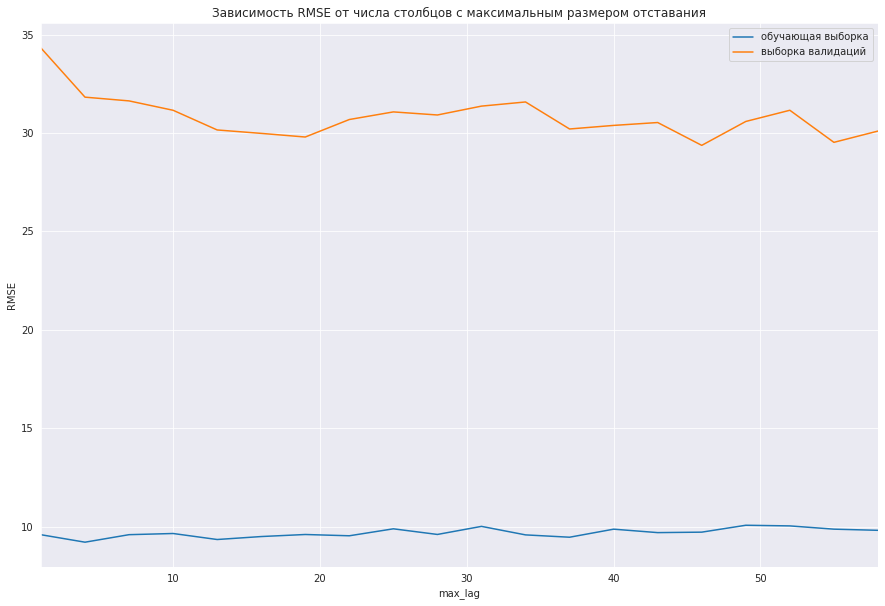

In [33]:
graph['ox'] = graph['ox'].astype('int')#Привожу данные в таблице к удобному типу для построения графика
graph['oy1'] = graph['oy1'].astype('float')
graph['oy2'] = graph['oy2'].astype('float')
ax = graph.plot(title = 'Зависимость RMSE от числа столбцов с максимальным размером отставания',x = 'ox', y= 'oy1', figsize=(15,10), grid=True, label='обучающая выборка')#Строю график
graph.plot(x = 'ox', y= 'oy2', ax=ax, grid=True, label='выборка валидаций')
ax.set_ylabel('RMSE')#Подписи осей
ax.set_xlabel('max_lag')#Подписи осей

Глубину дерева я подобрал перебором, а max_lag = 16 это наиболее оптимальное значение.

In [34]:
train_1, test = train_test_split(data, shuffle=False, test_size=0.1)#перезаписываю разбиения
train, valid = train_test_split(train_1, shuffle=False, test_size=0.1)

In [35]:
    
graph = pd.DataFrame(columns = ['ox', 'oy1', 'oy2'])#Задаю пустой список, в который потом будут вносится значения для построения графиков
a = 0#Счетчик цикла
for i in range(1,20,1):#Прогоняю параметры модели для поиска оптимальных значений
    data_11 = make_features(train_1, 16,i)
    train_1 = data_11.dropna()
    train, valid = train_test_split(train_1, shuffle=False, test_size=0.1)
    features_train = train.drop(['num_orders'], axis=1)
    target_train = train['num_orders']
    features_valid = valid.drop(['num_orders'], axis=1)
    target_valid = valid['num_orders']
    a += 1
    graph.loc[a,'ox'] = i#Задаю индекс строки пустого списка
    model = RandomForestRegressor(max_depth=30)#Создаю модель
    model.fit(features_train, target_train)#Обучаю
    train_predictions1 = model.predict(features_train)#Строю данные медли по тестовой выборке
    train_predictions2 = model.predict(features_valid)#Строю данные медли по валидационной выборке
    RMSE_1 = (mean_squared_error(target_train, train_predictions1))**(1/2)#Расчет качества модели
    RMSE_2 = (mean_squared_error(target_valid, train_predictions2))**(1/2)#Расчет качества модели
    graph.loc[a, 'oy1'] = RMSE_1#Добавляю значение в список
    graph.loc[a, 'oy2'] = RMSE_2#Добавляю значение в список
    print('rolling_mean_size=', i)#Выводжу параметры на экран
    print('RMSE для тестовой выборки: ', RMSE_1)#Выводжу параметры на экран
    print('RMSSE для валидационной выборки: ', RMSE_2)#Выводжу параметры на экран
    print()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 1
RMSE для тестовой выборки:  9.48187507072425
RMSSE для валидационной выборки:  30.07069868147262



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 2
RMSE для тестовой выборки:  9.39494992269258
RMSSE для валидационной выборки:  30.264417424185062



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 3
RMSE для тестовой выборки:  9.612801108606734
RMSSE для валидационной выборки:  30.006285177062928



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 4
RMSE для тестовой выборки:  9.68790857749256
RMSSE для валидационной выборки:  30.40776166227075



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 5
RMSE для тестовой выборки:  9.413197223232409
RMSSE для валидационной выборки:  30.55325992930529



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 6
RMSE для тестовой выборки:  9.851874739776799
RMSSE для валидационной выборки:  29.98265117994655



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 7
RMSE для тестовой выборки:  9.665277691991543
RMSSE для валидационной выборки:  31.01038044091751



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 8
RMSE для тестовой выборки:  9.517429312637443
RMSSE для валидационной выборки:  30.916793654422346



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 9
RMSE для тестовой выборки:  9.769223159894736
RMSSE для валидационной выборки:  29.922334052844793



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 10
RMSE для тестовой выборки:  9.812669305284862
RMSSE для валидационной выборки:  29.389959664473377



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 11
RMSE для тестовой выборки:  9.743595081596004
RMSSE для валидационной выборки:  29.10932309054049



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 12
RMSE для тестовой выборки:  9.643547309042132
RMSSE для валидационной выборки:  30.933210457933853



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 13
RMSE для тестовой выборки:  9.641473957072948
RMSSE для валидационной выборки:  30.21175443599388



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 14
RMSE для тестовой выборки:  9.36690913090688
RMSSE для валидационной выборки:  29.207174004571776



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 15
RMSE для тестовой выборки:  9.73509620341051
RMSSE для валидационной выборки:  30.39322232701096



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 16
RMSE для тестовой выборки:  9.50090286158615
RMSSE для валидационной выборки:  30.12715614913576



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 17
RMSE для тестовой выборки:  9.623962080687221
RMSSE для валидационной выборки:  28.881482889705573



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 18
RMSE для тестовой выборки:  9.701904416452198
RMSSE для валидационной выборки:  29.042786397562086



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 19
RMSE для тестовой выборки:  9.574538130188323
RMSSE для валидационной выборки:  29.947535414190533



Text(0.5, 0, 'rolling_mean_size')

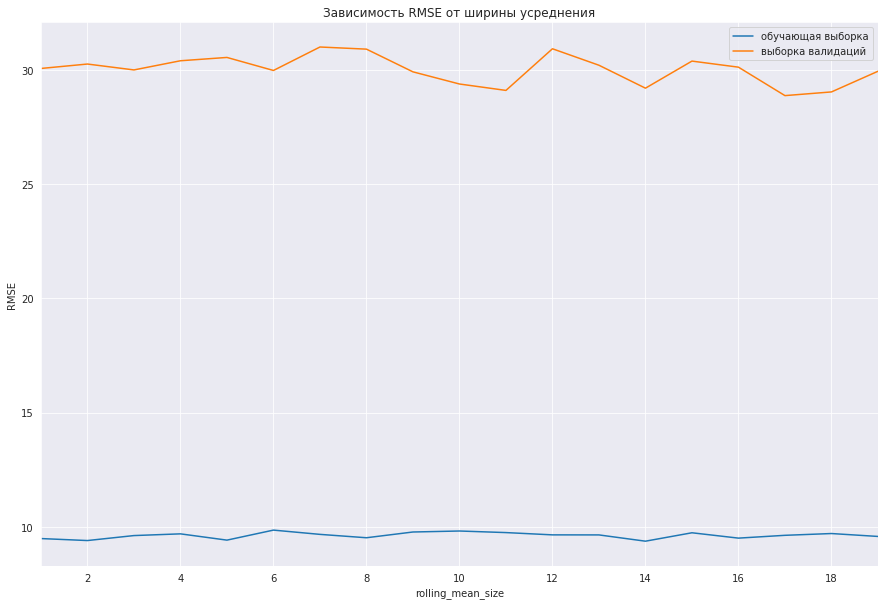

In [36]:
graph['ox'] = graph['ox'].astype('int')#Привожу данные в таблице к удобному типу для построения графика
graph['oy1'] = graph['oy1'].astype('float')
graph['oy2'] = graph['oy2'].astype('float')
ax = graph.plot(title = 'Зависимость RMSE от ширины усреднения',x = 'ox', y= 'oy1', figsize=(15,10), grid=True, label='обучающая выборка')#Строю график
graph.plot(x = 'ox', y= 'oy2', ax=ax, grid=True, label='выборка валидаций')
ax.set_ylabel('RMSE')#Подписи осей
ax.set_xlabel('rolling_mean_size')#Подписи осей

Видимо глубиной дерева я настроился на лучшее качество при усреднении=1 и чтоб качество вывести на лучший уровень нужно перебирать на каждом уровне усреднения, ну ладно, оставим так.

In [37]:
train_1, test = train_test_split(data, shuffle=False, test_size=0.1)#перезаписываю разбиения
train, valid = train_test_split(train_1, shuffle=False, test_size=0.1)

In [38]:
data_11 = make_features(train_1, 16,1)
train_1 = data_11.dropna()
train, valid = train_test_split(train_1, shuffle=False, test_size=0.1)
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']
model = RandomForestRegressor(max_depth=30)#Создаю модель
model.fit(features_train, target_train)#Обучаю

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [39]:
print('RMSE случайного леса',(mean_squared_error(model.predict(features_valid),target_valid))**(1/2))

RMSE случайного леса 30.358366293995534


Попробуем обучить модель опорных векторов.

In [40]:
train_1, test = train_test_split(data, shuffle=False, test_size=0.1)#перезаписываю разбиения
train, valid = train_test_split(train_1, shuffle=False, test_size=0.1)

In [41]:
graph = pd.DataFrame(columns = ['ox', 'oy1', 'oy2'])#Задаю пустой список, в который потом будут вносится значения для построения графиков
a = 0#Счетчик цикла
for i in range(1,60,3):#Прогоняю параметры модели для поиска оптимальных значений
    data_11 = make_features(train_1, i,1)#генерю в цикле фичи для разбиения выборки
    train_1 = data_11.dropna()
    train, valid = train_test_split(train_1, shuffle=False, test_size=0.1)
    features_train = train.drop(['num_orders'], axis=1)
    target_train = train['num_orders']
    features_valid = valid.drop(['num_orders'], axis=1)
    target_valid = valid['num_orders']
    a += 1
    graph.loc[a,'ox'] = i#Задаю индекс строки пустого списка
    model = SVR(kernel='linear')#Создаю модель
    model.fit(features_train, target_train)#Обучаю
    train_predictions1 = model.predict(features_train)#Строю данные медли по тестовой выборке
    train_predictions2 = model.predict(features_valid)#Строю данные медли по валидационной выборке
    RMSE_1 = (mean_squared_error(target_train, train_predictions1))**(1/2)#Расчет качества модели
    RMSE_2 = (mean_squared_error(target_valid, train_predictions2))**(1/2)#Расчет качества модели
    graph.loc[a, 'oy1'] = RMSE_1#Добавляю значение в список
    graph.loc[a, 'oy2'] = RMSE_2#Добавляю значение в список
    print('max_lag=', i)#Выводжу параметры на экран
    print('RMSE для тестовой выборки: ', RMSE_1)#Выводжу параметры на экран
    print('RMSSE для валидационной выборки: ', RMSE_2)#Выводжу параметры на экран
    print()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 1
RMSE для тестовой выборки:  29.420766778988753
RMSSE для валидационной выборки:  39.59759747738818



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 4
RMSE для тестовой выборки:  29.307175719609646
RMSSE для валидационной выборки:  39.07964095442154



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 7
RMSE для тестовой выборки:  29.301895275941064
RMSSE для валидационной выборки:  39.123999242013625



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 10
RMSE для тестовой выборки:  29.086579773094073
RMSSE для валидационной выборки:  38.801784144116766



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 13
RMSE для тестовой выборки:  29.009581405382075
RMSSE для валидационной выборки:  38.75255629359852



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 16
RMSE для тестовой выборки:  28.765499437354286
RMSSE для валидационной выборки:  38.316994514476114



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 19
RMSE для тестовой выборки:  28.04724807833965
RMSSE для валидационной выборки:  36.854898722319234



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 22
RMSE для тестовой выборки:  27.64746428603397
RMSSE для валидационной выборки:  36.09009851586741



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 25
RMSE для тестовой выборки:  25.05233232302003
RMSSE для валидационной выборки:  32.895276377482396



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 28
RMSE для тестовой выборки:  24.644660383231752
RMSSE для валидационной выборки:  32.66128721188019



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 31
RMSE для тестовой выборки:  24.580117209197454
RMSSE для валидационной выборки:  32.71771776947103



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 34
RMSE для тестовой выборки:  24.48907012953303
RMSSE для валидационной выборки:  32.527364723942405



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 37
RMSE для тестовой выборки:  24.512676584000616
RMSSE для валидационной выборки:  32.44589297626815



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 40
RMSE для тестовой выборки:  24.489649640090082
RMSSE для валидационной выборки:  32.387378042139076



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 43
RMSE для тестовой выборки:  24.53780211720478
RMSSE для валидационной выборки:  32.62907795926661



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 46
RMSE для тестовой выборки:  24.442137207596723
RMSSE для валидационной выборки:  31.90921954062575



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 49
RMSE для тестовой выборки:  22.999440339148677
RMSSE для валидационной выборки:  29.74151211670595



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 52
RMSE для тестовой выборки:  23.05852994507887
RMSSE для валидационной выборки:  29.696118377914324



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 55
RMSE для тестовой выборки:  23.144712770850088
RMSSE для валидационной выборки:  29.568602663296378



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



max_lag= 58
RMSE для тестовой выборки:  23.10874544313678
RMSSE для валидационной выборки:  29.60826919833562



Text(0.5, 0, 'max_lag')

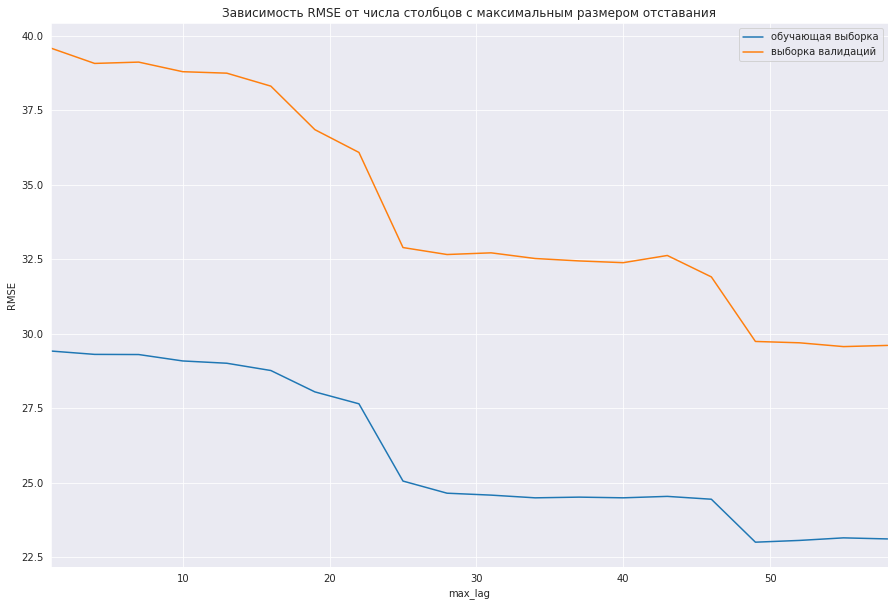

In [42]:
graph['ox'] = graph['ox'].astype('int')#Привожу данные в таблице к удобному типу для построения графика
graph['oy1'] = graph['oy1'].astype('float')
graph['oy2'] = graph['oy2'].astype('float')
ax = graph.plot(title = 'Зависимость RMSE от числа столбцов с максимальным размером отставания',x = 'ox', y= 'oy1', figsize=(15,10), grid=True, label='обучающая выборка')#Строю график
graph.plot(x = 'ox', y= 'oy2', ax=ax, grid=True, label='выборка валидаций')
ax.set_ylabel('RMSE')#Подписи осей
ax.set_xlabel('max_lag')#Подписи осей

In [43]:
train_1, test = train_test_split(data, shuffle=False, test_size=0.1)#перезаписываю разбиения
train, valid = train_test_split(train_1, shuffle=False, test_size=0.1)
graph = pd.DataFrame(columns = ['ox', 'oy1', 'oy2'])#Задаю пустой список, в который потом будут вносится значения для построения графиков
a = 0#Счетчик цикла
for i in range(20,35,3):#Прогоняю параметры модели для поиска оптимальных значений
    data_11 = make_features(train_1, 50,i)
    train_1 = data_11.dropna()
    train, valid = train_test_split(train_1, shuffle=False, test_size=0.1)
    features_train = train.drop(['num_orders'], axis=1)
    target_train = train['num_orders']
    features_valid = valid.drop(['num_orders'], axis=1)
    target_valid = valid['num_orders']
    a += 1
    graph.loc[a,'ox'] = i#Задаю индекс строки пустого списка
    model = SVR(kernel='linear')#Создаю модель
    model.fit(features_train, target_train)#Обучаю
    train_predictions1 = model.predict(features_train)#Строю данные медли по тестовой выборке
    train_predictions2 = model.predict(features_valid)#Строю данные медли по валидационной выборке
    RMSE_1 = (mean_squared_error(target_train, train_predictions1))**(1/2)#Расчет качества модели
    RMSE_2 = (mean_squared_error(target_valid, train_predictions2))**(1/2)#Расчет качества модели
    graph.loc[a, 'oy1'] = RMSE_1#Добавляю значение в список
    graph.loc[a, 'oy2'] = RMSE_2#Добавляю значение в список
    print('rolling_mean_size=', i)#Выводжу параметры на экран
    print('RMSE для тестовой выборки: ', RMSE_1)#Выводжу параметры на экран
    print('RMSSE для валидационной выборки: ', RMSE_2)#Выводжу параметры на экран
    print()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 20
RMSE для тестовой выборки:  28.20155329259871
RMSSE для валидационной выборки:  35.37981885244839



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 23
RMSE для тестовой выборки:  25.038164782246092
RMSSE для валидационной выборки:  31.25311256949675



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 26
RMSE для тестовой выборки:  27.275458957894557
RMSSE для валидационной выборки:  35.39602058462668



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 29
RMSE для тестовой выборки:  23.315630199405916
RMSSE для валидационной выборки:  29.97085561456825



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



rolling_mean_size= 32
RMSE для тестовой выборки:  25.43528740934989
RMSSE для валидационной выборки:  32.609815027064805



Text(0.5, 0, 'rolling_mean_size')

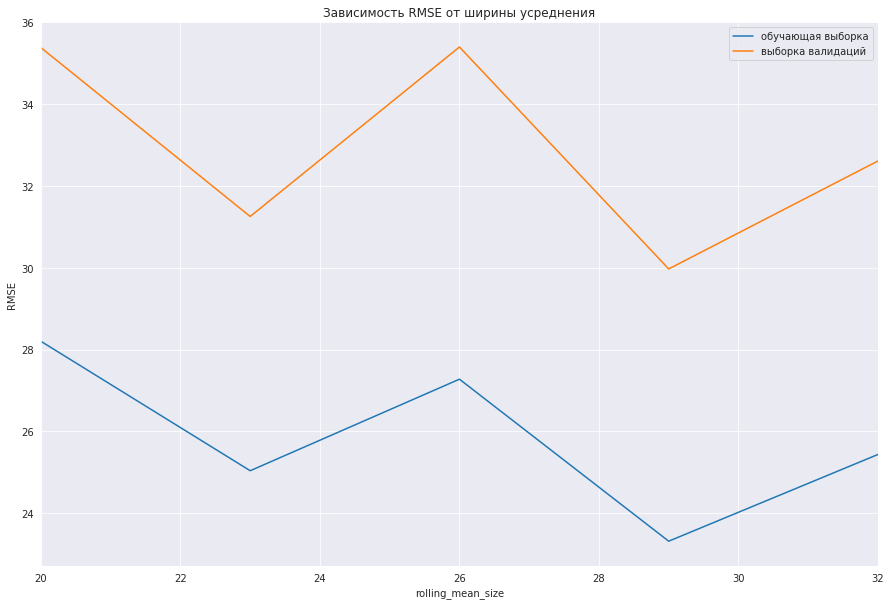

In [44]:
graph['ox'] = graph['ox'].astype('int')#Привожу данные в таблице к удобному типу для построения графика
graph['oy1'] = graph['oy1'].astype('float')
graph['oy2'] = graph['oy2'].astype('float')
ax = graph.plot(title = 'Зависимость RMSE от ширины усреднения',x = 'ox', y= 'oy1', figsize=(15,10), grid=True, label='обучающая выборка')#Строю график
graph.plot(x = 'ox', y= 'oy2', ax=ax, grid=True, label='выборка валидаций')
ax.set_ylabel('RMSE')#Подписи осей
ax.set_xlabel('rolling_mean_size')#Подписи осей

Я долго перебирал усреднение и пришел к выводу что оно только ухудшает качество модели, по этому приравняю его к 1.

In [45]:
train_1, test = train_test_split(data, shuffle=False, test_size=0.1)#перезаписываю разбиения
train, valid = train_test_split(train_1, shuffle=False, test_size=0.1)
data_11 = make_features(train_1, 50,1)
train_1 = data_11.dropna()
train, valid = train_test_split(train_1, shuffle=False, test_size=0.1)
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']
model = SVR(kernel='linear')#Создаю модель
model.fit(features_train, target_train)#Обучаю

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [46]:
print('RMSE модели опорных векторов',(mean_squared_error(model.predict(features_valid),target_valid))**(1/2))

RMSE модели опорных векторов 29.511146705900952


Вывод: были построены модели для предсказания времянного ряда. ARIMA справилась хуже всех, остальные модели примерно одинакового качества, регрессия случайного леса показала хороший результат при меньшем количестве лагов, что упрощает и ускоряет предсказание, качество при этом не сильно хуже остальных, модель линейной регрессии отличилась своей простотой, а метод опорных векторов показался мне сильно чувствительных ко входным данным и что-угодно ему не "скормишь".

# 4. Тестирование

Запишу показатели качества моделей на валидации, что бы сравнить потом на тесте.

In [47]:
train_1, test = train_test_split(data, shuffle=False, test_size=0.1)

In [48]:
d = [['ARIMA',44.56],['LinearRegression',29.02],['RandomForestRegressor',29.48],['SVR',29.51]]
itog = pd.DataFrame(d,columns=['model','RMSE_validation'])
itog

,model,RMSE_validation
0,ARIMA,44.56
1,LinearRegression,29.02
2,RandomForestRegressor,29.48
3,SVR,29.51


In [49]:
model_ARIMA = sm.tsa.ARIMA(data[:'2018-08-13 13:00:00'], order=(6,0,3)).fit(full_output=False, disp=0,MaxIter=700)#

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [50]:
pred = model_ARIMA.predict('2018-08-13 14:00:00','2018-08-31 23:00:00')
print('RMSE ARIMA',(mean_squared_error(pred,test))**(1/2))

RMSE ARIMA 61.520146407671646


In [51]:
data_11 = make_features(data, 50,11)
train_1 = data_11.dropna()
train, test = train_test_split(train_1, shuffle=False, test_size=0.1)
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
model_lr = LinearRegression()#Создаю модель
model_lr.fit(features_train, target_train)#Обучаю

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [52]:
print('RMSE линейной регрессии',(mean_squared_error(model_lr.predict(features_test),target_test))**(1/2))

RMSE линейной регрессии 39.17200186355968


In [53]:
data_11 = make_features(train_1, 16,1)
train_1 = data_11.dropna()
train, test = train_test_split(train_1, shuffle=False, test_size=0.1)
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
model_rf = RandomForestRegressor(max_depth=30)#Создаю модель
model_rf.fit(features_train, target_train)#Обучаю

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [54]:
print('RMSE случайного леса',(mean_squared_error(model_rf.predict(features_test),target_test))**(1/2))

RMSE случайного леса 39.748438847388684


In [55]:
data_11 = make_features(train_1, 50,1)
train_1 = data_11.dropna()
train, test = train_test_split(train_1, shuffle=False, test_size=0.1)
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
model_svr = SVR(kernel='linear')#Создаю модель
model_svr.fit(features_train, target_train)#Обучаю

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [56]:
print('RMSE опорных векторов',(mean_squared_error(model_svr.predict(features_test),target_test))**(1/2))

RMSE опорных векторов 40.570003869587914


Как видим качество моделей на тесте заметно снизилось. Это связано с недостатком информации в самих данных, анализируя график виден больший подьем среднего нежели в начале времени, этот скачек трудно предсказать опираясь лишь на размеренно растущие данные до него + для большего количества данных (так как ранее модели обучались на 80% данных, а сейчас на 90%х) необходим переподбор параметров.

Проанализируем ошибки линейной регрессии.

In [57]:
data_11 = make_features(data, 50,11)
train_1 = data_11.dropna()
train, test = train_test_split(train_1, shuffle=False, test_size=0.1)
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
model_lr = LinearRegression()#Создаю модель
model_lr.fit(features_train, target_train)#Обучаю
prd = pd.DataFrame(model_lr.predict(features_test),index=target_test.index,columns=['model'])
prd['model']=prd['model'].astype(int)
real = pd.DataFrame(target_test)

In [58]:
(abs(prd['model']-real['num_orders'])).describe()

count    437.000000
mean      30.421053
std       24.944182
min        0.000000
25%       11.000000
50%       25.000000
75%       42.000000
max      144.000000
dtype: float64

In [59]:
razn = pd.DataFrame(abs(prd['model']-real['num_orders']),columns=['razn'])
div = razn.loc[razn['razn']>=42]

In [60]:
div['day'] = div.index.day
div['dayofweek'] = div.index.dayofweek
div['hour'] = div.index.hour
div

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

,razn,day,dayofweek,hour
datetime,,,,
2018-08-13 21:00:00,52,13,0,21
2018-08-14 01:00:00,44,14,1,1
2018-08-14 02:00:00,87,14,1,2
2018-08-14 03:00:00,58,14,1,3
2018-08-14 10:00:00,45,14,1,10
...,...,...,...,...
2018-08-31 04:00:00,141,31,4,4
2018-08-31 08:00:00,65,31,4,8
2018-08-31 13:00:00,52,31,4,13


Text(0.5, 1.0, 'Распределение числа ошибок в зависимости от дня месяца')

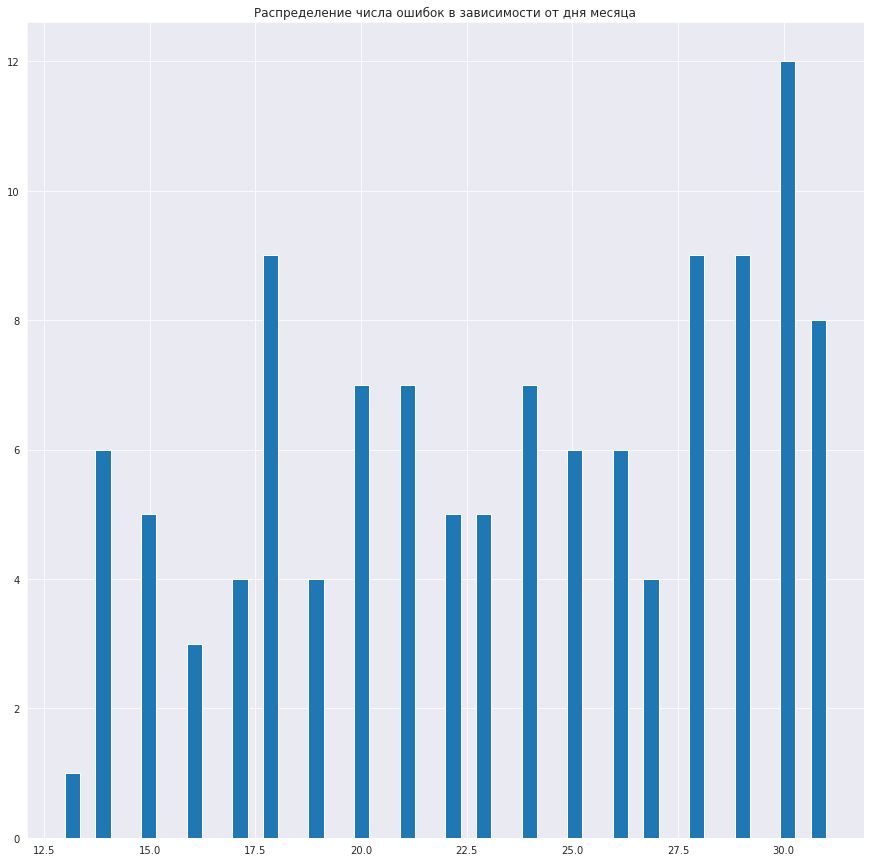

In [61]:
div['day'].hist(figsize=(15,15),bins=50)
plt.title('Распределение числа ошибок в зависимости от дня месяца')

Text(0.5, 1.0, 'Распределение числа ошибок в зависимости от дня недели')

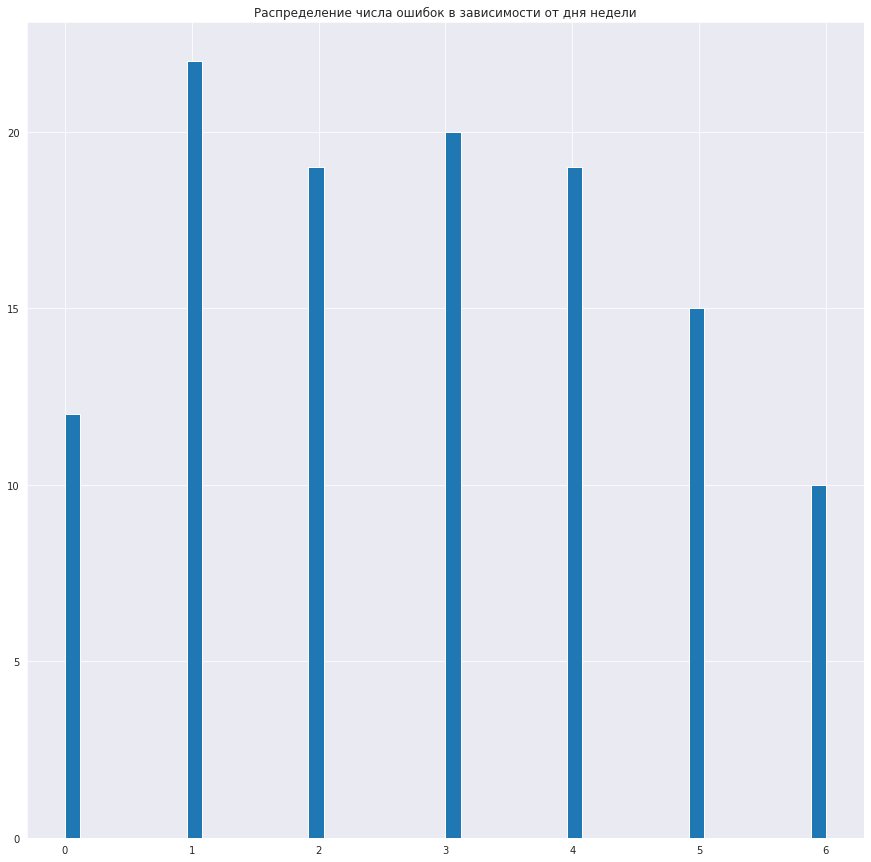

In [62]:
div['dayofweek'].hist(figsize=(15,15),bins=50)
plt.title('Распределение числа ошибок в зависимости от дня недели')

Text(0.5, 1.0, 'Распределение числа ошибок в зависимости от часа дня')

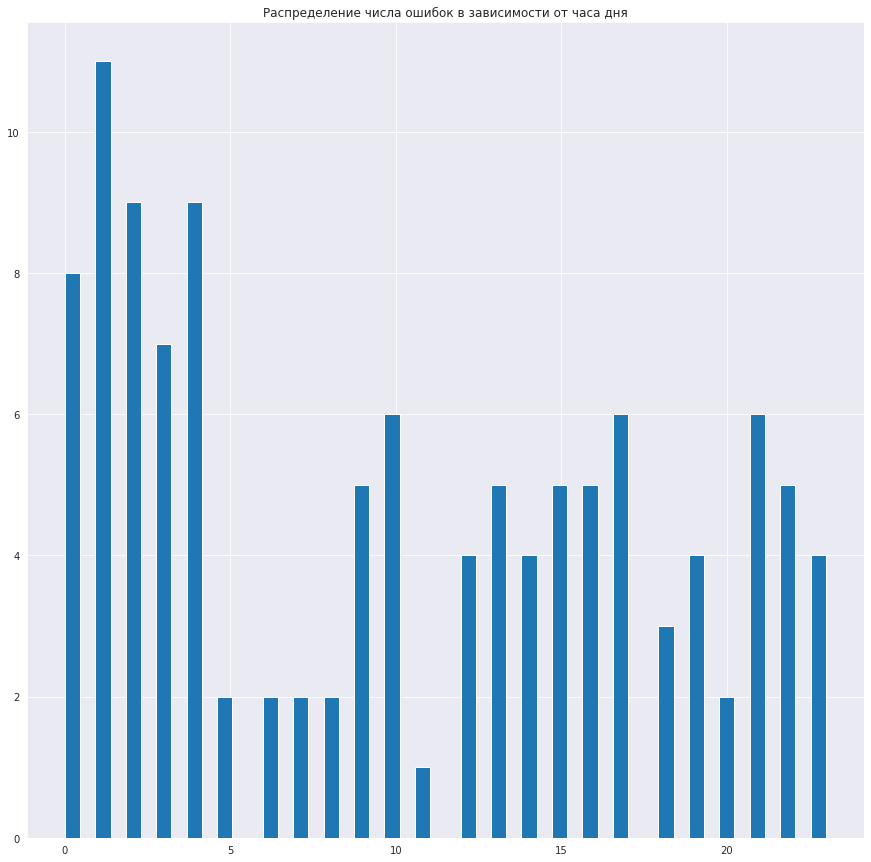

In [63]:
div['hour'].hist(figsize=(15,15),bins=50)
plt.title('Распределение числа ошибок в зависимости от часа дня')

<function matplotlib.pyplot.show(*args, **kw)>

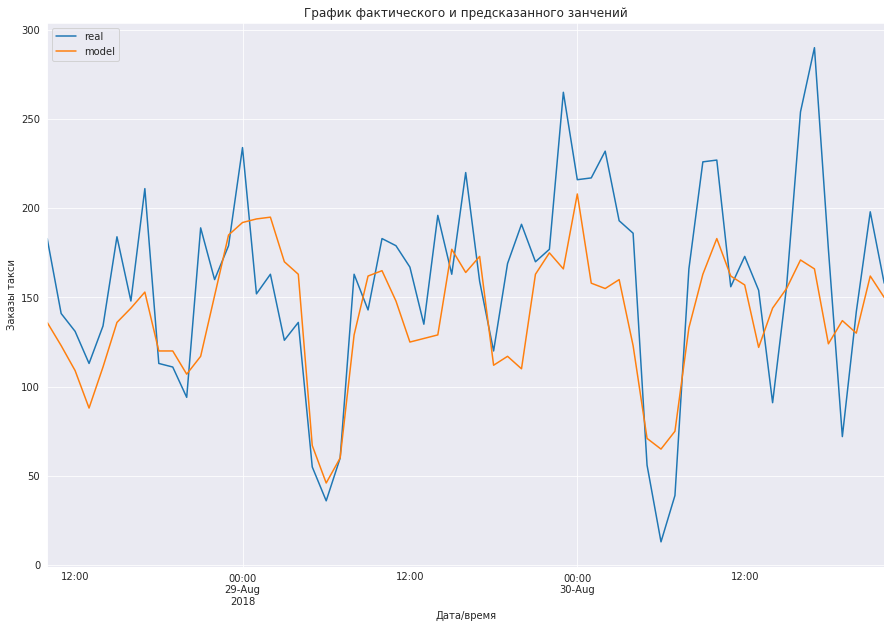

In [88]:
plt.title('График фактического и предсказанного занчений')
ax = data['2018-08-28 10:00:00':'2018-08-30 22:00:00']['num_orders'].plot(figsize=(15,10), grid=True,legend=True, label='real')#Строю график
prd['2018-08-28 10:00:00':'2018-08-30 22:00:00'].plot(ax=ax, grid=True, label='model')
ax.set_ylabel('Заказы такси')#Подписи осей
ax.set_xlabel('Дата/время')#Подписи осей
plt.show

Судя по графику: модель в целом "концепцию" данных улавливает, ошибается она лишь в масштабе, не доходя до реальных значений. Точнее всего модель предсказывает вечером примерно 18:00 и ночью примерно в 4. А хуже всего в остальное время.

По анализу ошибок тредно определить где модель больше ошибается, проще сказать где модель точнее всего- это 5-8 часов ночи и 11 часов утра.

Был проанализирован времянной ряд. В ходе анализа выяснилось что он нормально распределен и стационарен. Были построены модели, прогнозирующие ряд. На валидации модели показали себя хорошо, но вот на тесте результат заметно ухудшился, думаю это связанно с довольно таким резким подьемом среднего в конце выборки. Выяснилось что скользящее среднее не сильно информативно для модели, пытающейся предсказать данный времянной ряд.